# Deep Convnet for each question



a stacked deep convnet for each individual question similar to VGG for images:

```
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)
```

## Import packages

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json

from keras.models import Sequential,Model
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, Lambda, Activation
from keras.layers import Conv1D , Flatten, Input
from keras.layers.pooling import MaxPooling1D
from keras.layers.convolutional import ZeroPadding1D



from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint,EarlyStopping
from keras import backend as K





from sklearn.model_selection import train_test_split


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5103)


## Initialize global variables

In [2]:


path = '/home/ubuntu/quora/'
data_home = path +"data/"

Q1_TRAINING_DATA_FILE = data_home+'cache/q1_train.npy'
Q2_TRAINING_DATA_FILE = data_home+'cache/q2_train.npy'
LABEL_TRAINING_DATA_FILE = data_home+'cache/label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = data_home+'cache/word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = data_home+'cache/nb_words.json'
Q1_TESTING_DATA_FILE = 'q1_test.npy'
Q2_TESTING_DATA_FILE = 'q2_test.npy'


MODEL_WEIGHTS_FILE = path+'weights/conv_weights_v1.h5'
MAX_SEQUENCE_LENGTH = 35
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25

## Load the dataset, embedding matrix and word count

In [3]:
q1_data = np.load(open(Q1_TRAINING_DATA_FILE, 'rb'))
q2_data = np.load(open(Q2_TRAINING_DATA_FILE, 'rb'))
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))
word_embedding_matrix = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']

In [4]:
q1_data.shape,q2_data.shape

((404290, 35), (404290, 35))

## Partition the dataset into train and test sets

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=2019)


In [6]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
# Q1_train = X_train[:,0]
# Q2_train = X_train[:,1]
# Q1_test = X_test[:,0]
# Q2_test = X_test[:,1]

In [7]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]



TRAIN: [337176  17039  75113 ...,  41001 336218 115328] TEST: [283851 377233  35357 ..., 392228 325350 150065]


In [8]:
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

setting weights

In [9]:
class_weight = {0: 1.309028344, 1: 0.472001959}
weight_val = np.ones(len(y_test))
weight_val *= 0.472001959
weight_val[y_test==0] = 1.309028344   

## Define the model

In [10]:

nr_hidden = 200
drop_out = 0.2 

In [11]:
def ConvBlock(x, num_blocks=2, filters=32):

    for i in range(num_blocks):
#         x = ZeroPadding1D(1)(x)
        x = Conv1D(filters, kernel_size=4, padding='valid',activation='relu')(x)
        x = BatchNormalization()(x)        
        x = Dropout(drop_out)(x)
        
#     x =  MaxPooling1D(2)(x)
    
    return x          

In [14]:
from keras.layers.pooling import GlobalMaxPooling1D,GlobalAveragePooling1D
from keras.layers.merge import concatenate


graph_in = Input(shape=(MAX_SEQUENCE_LENGTH,EMBEDDING_DIM))
x = BatchNormalization()(graph_in)



## v4

x = ConvBlock(x,2,32)
x = ConvBlock(x,2,64)

maxpool = GlobalMaxPooling1D()(x)
avgpool = GlobalAveragePooling1D()(x)

features = concatenate([maxpool,avgpool])

x = Dense(nr_hidden, activation='relu')(features)
x = BatchNormalization()(x)
x = Dropout(drop_out)(x)

## v3

# x = ConvBlock(x,2,32)
# x = ConvBlock(x,2,64)

# x = GlobalMaxPooling1D()(x)

# x = Dense(nr_hidden)(x)
# x = BatchNormalization()(x)
# x = Dropout(drop_out)(x)

## v2
# x = ConvBlock(x,2,32)
# x = ConvBlock(x,2,64)
# x = ConvBlock(x,2,128)

## v1
# x = ZeroPadding1D(1)(x)

# the first two layers
# x = ZeroPadding1D(1)(graph_in)
# x = Conv1D(32, 2, activation='relu')(graph_in)
# x = Dropout(0.2)(x)
# # x = MaxPooling1D(2)(x)

# # x = ZeroPadding1D(1)(graph_in)
# x = Conv1D(32, 3, activation='relu')(x)
# x = BatchNormalization()(x)
# x = MaxPooling1D(2)(x)


# deep conv layers
# x = ConvBlock(x,2,128)
# x = ConvBlock(x,3,256)
# x = ConvBlock(x,3,512)
# x = ConvBlock(x,3,512)
# x = Flatten()(x)

stackedConvLayers = Model(inputs=graph_in,outputs=x)


### add computation graph to question 1 embeddings

Q1 = Sequential()
Q1.add(Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False))


Q1.add(stackedConvLayers)


### Same ops for question 2

Q2 = Sequential()
Q2.add(Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False))


Q2.add(stackedConvLayers)


model = Sequential()



# vanilla dense:

model.add(Merge([Q1, Q2], mode='concat'))


model.add(BatchNormalization())

model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(drop_out))

model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(drop_out))

model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='nadam', 
              metrics=['accuracy'])#, 'precision', 'recall', 'fbeta_score'])

/home/ubuntu/anaconda2/envs/qenv/lib/python2.7/site-packages/ipykernel/__main__.py:97: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [12]:
# stackedConvLayers.summary()

In [13]:
# model.summary()

## Siamese Style distance function

In [14]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


In [24]:
def create_siamese_model():
    
    graph_in = Input(shape=(MAX_SEQUENCE_LENGTH,))
    
    embedded = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(graph_in)
    
    
    x = BatchNormalization()(embedded)

    
## v5

    x = MaxPooling1D(pool_size=3)(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = GlobalMaxPooling1D()(x)
    


    
    
    
    
    ## v4

#     x = ConvBlock(x,2,32)
#     x = MaxPooling1D()(x)
#     x = ConvBlock(x,2,64)
#     x = MaxPooling1D()(x)
 


#     x = Flatten()(x)
#     maxpool = GlobalMaxPooling1D()(x)
#     avgpool = GlobalAveragePooling1D()(x)

#     features = concatenate([maxpool,avgpool])

    x = Dense(nr_hidden, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(drop_out)(x)

    x = Dense(nr_hidden, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(drop_out)(x)

    return Model(inputs=graph_in,outputs=x)

In [25]:
from keras.layers.pooling import GlobalMaxPooling1D,GlobalAveragePooling1D
from keras.layers.merge import concatenate


input_a = Input(shape=(MAX_SEQUENCE_LENGTH,))
input_b = Input(shape=(MAX_SEQUENCE_LENGTH,))


siamese = create_siamese_model()




# Siamese style Euclidean distance:

processed_a = siamese(input_a)
processed_b = siamese(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

distance = Dense(1, activation='sigmoid')(distance)
model = Model([input_a, input_b], distance)

# vanilla dense:

# model.compile(loss=contrastive_loss, optimizer="nadam",metrics=['accuracy'])

model.compile(loss='binary_crossentropy', 
              optimizer='nadam', 
              metrics=['accuracy'])#, 'precision', 'recall', 'fbeta_score'])

In [27]:
# siamese.summary()

## Train the model, checkpointing weights with best validation accuracy

In [15]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()


MODEL_WEIGHTS_FILE = path+'weights/deepconv_2x32_2x64_gmax_gavg_prepC_fixedweights_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.h5'

early_stopping =EarlyStopping(monitor='val_loss', patience=4)
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_loss', save_best_only=True),early_stopping]

history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=50,
                    batch_size=256,
                    validation_data = ([Q1_test, Q2_test],y_test,weight_val),
                    class_weight=class_weight,
                    callbacks=callbacks,shuffle=True)

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2017-05-02 13:55:14.442019
Train on 363861 samples, validate on 40429 samples
Epoch 1/50
363861/363861 [==============================] - 78s - loss: 0.4028 - acc: 0.6748 - val_loss: 0.3966 - val_acc: 0.6975
Epoch 2/50
363861/363861 [==============================] - 78s - loss: 0.3583 - acc: 0.7124 - val_loss: 0.3492 - val_acc: 0.7233
Epoch 3/50
363861/363861 [==============================] - 78s - loss: 0.3464 - acc: 0.7241 - val_loss: 0.3429 - val_acc: 0.7132
Epoch 4/50
363861/363861 [==============================] - 78s - loss: 0.3383 - acc: 0.7325 - val_loss: 0.3302 - val_acc: 0.7396
Epoch 5/50
363861/363861 [==============================] - 78s - loss: 0.3324 - acc: 0.7383 - val_loss: 0.3269 - val_acc: 0.7367
Epoch 6/50
363861/363861 [==============================] - 77s - loss: 0.3272 - acc: 0.7434 - val_loss: 0.3313 - val_acc: 0.7131
Epoch 7/50
363861/363861 [==============================] - 78s - loss: 0.3227 - acc: 0.7471 - val_loss: 0.3221 - val_acc

## Plot training and validation accuracy

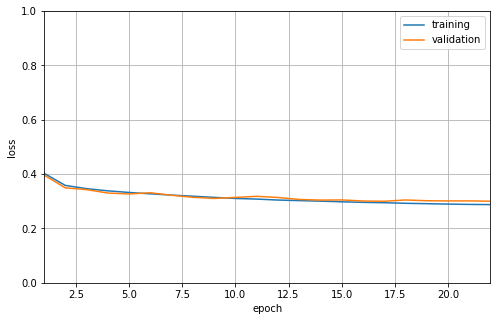

In [16]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['loss'],
                    'validation': history.history['val_loss']})
ax = acc.ix[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("loss")
ax.set_ylim([0.0,1.0]);

## Print best validation accuracy and epoch

without cleaning: Maximum accuracy at epoch 8 = 0.8227
with cleaning: Maximum accuracy at epoch 15 = 0.8268
with cleaning and stratified: 0.8275

In [69]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Maximum loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_val_loss))

Maximum loss at epoch 35 = 0.2896


## Evaluate the model with best validation accuracy on the test partition

In [46]:
# model.load_weights(MODEL_WEIGHTS_FILE)
# loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test) #, precision, recall, fbeta_score
# print('')
# print('loss      = {0:.4f}'.format(loss))
# print('accuracy  = {0:.4f}'.format(accuracy))
# # print('precision = {0:.4f}'.format(precision))
# print('recall    = {0:.4f}'.format(recall))
# print('F         = {0:.4f}'.format(fbeta_score))

In [17]:
model.load_weights(path+"weights/deepconv_2x32_2x64_gmax_gavg_prepC_fixedweights_epoch_16_val_loss_0.30.h5")

In [18]:
val_preds = model.predict([Q1_test, Q2_test])

from sklearn.metrics import log_loss


print (log_loss(y_test,val_preds))
print (log_loss(y_test,np.clip(val_preds,1-0.90,0.90)))
print (log_loss(y_test,np.clip(val_preds,1-0.98,0.98)))
print (log_loss(y_test,np.clip(val_preds,1-0.99,0.99)))


0.464873303266
0.471671306509
0.464492488003
0.464592693059


2x64 kernel:2 dropout:0.1
0.381922677204



## Making predictions on test set

In [19]:
q1_test_data = np.load(open(data_home+"cache/"+Q1_TESTING_DATA_FILE, 'rb'))
q2_test_data = np.load(open(data_home+"cache/"+Q2_TESTING_DATA_FILE, 'rb'))

In [20]:
%%time
preds = model.predict([q1_test_data,q2_test_data], batch_size=256)
preds_reverse = model.predict([q2_test_data,q1_test_data], batch_size=256)

CPU times: user 3min 2s, sys: 34.9 s, total: 3min 37s
Wall time: 3min 37s


In [21]:
preds.shape

(2345796, 1)

In [22]:
preds = (preds+preds_reverse)/2.0

In [23]:
clip =0.98

submission_name = "subm/deep_conv_2x32_2x64_gmax_gavg_fixedweight_reverseaug_c98.csv"
flattend = preds.flatten()

clipped = np.clip(flattend,1-clip,clip)

In [24]:
df_test = pd.read_csv(data_home+'test.csv')

sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': clipped})
sub.head(2)

,is_duplicate,test_id
0,0.021083,0
1,0.023120,1


In [25]:
sub.to_csv(path+submission_name, index=False)

In [26]:
from IPython.lib.display import FileLink

FileLink(submission_name)

/home/ubuntu/quora/subm/deep_conv_2x32_2x64_gmax_gavg_fixedweight_reverseaug_c98.csv